In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import keras
from keras import layers
import numpy as np
from sklearn.model_selection import train_test_split


## MNIST Solution

#### Download MNIST Dataset

In [3]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.mnist.load_data()

#### Normalizing

In [4]:
x_train_full = (x_train_full/255.0).astype('float32')[..., None] # (n, 28, 28, 1)
x_test = (x_test/255.0).astype('float32')[..., None]

#### Split for training and testing

In [5]:

x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.1, random_state=42)
print(x_train.shape, x_val.shape, x_test.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (10000, 28, 28, 1)


#### Build a model

In [63]:
# Augmentation layer for training
data_aug = keras.Sequential([
    layers.RandomRotation(0.05),
    layers.RandomTranslation(0.05, 0.05),
], name="aug")

def build_model(filters=16):
    inp = keras.Input(shape=(28,28,1))
    x = data_aug(inp)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(name="pool1")(x)
    x = layers.Conv2D(filters*2, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(name="pool2")(x)
    x= layers.Flatten()(x)
    x= layers.Dense(128, activation="relu")(x)
    out = layers.Dense(10)(x)
    return (inp, out)

model= keras.Model(*build_model())

In [ ]:
model.compile(
    keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)
model.summary()

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug (Sequential)                │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,922 (808.29 KB)

 Trainable params: 206,922 (808.29 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
hist = model.fit(
    *(x_train, y_train),
    epochs=3,
    batch_size=128,
    validation_data=(x_val, y_val)
)

Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8848 - loss: 0.3805 - val_accuracy: 0.9753 - val_loss: 0.0796
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9638 - loss: 0.1169 - val_accuracy: 0.9840 - val_loss: 0.0575
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9728 - loss: 0.0863 - val_accuracy: 0.9843 - val_loss: 0.0542


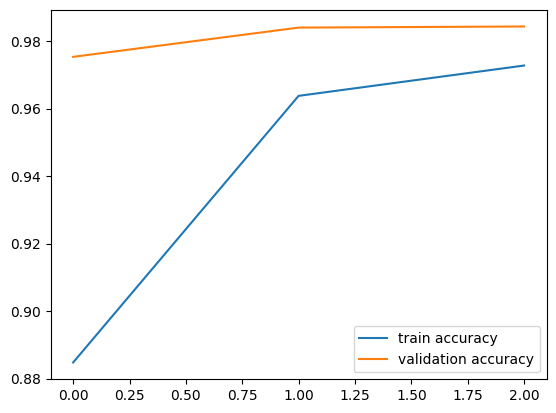

In [66]:
plt.figure()
plt.plot(hist.history['accuracy'], label="train accuracy")
plt.plot(hist.history['val_accuracy'], label="validation accuracy")
plt.legend()

In [67]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy: {test_acc*100:.5f}%, Loss: {test_loss*100:.5f}%")

Accuracy: 98.72000%, Loss: 3.99199%


## Solution Analysis

#### Plot Wrong preditions

Wrong predictions for 84 images


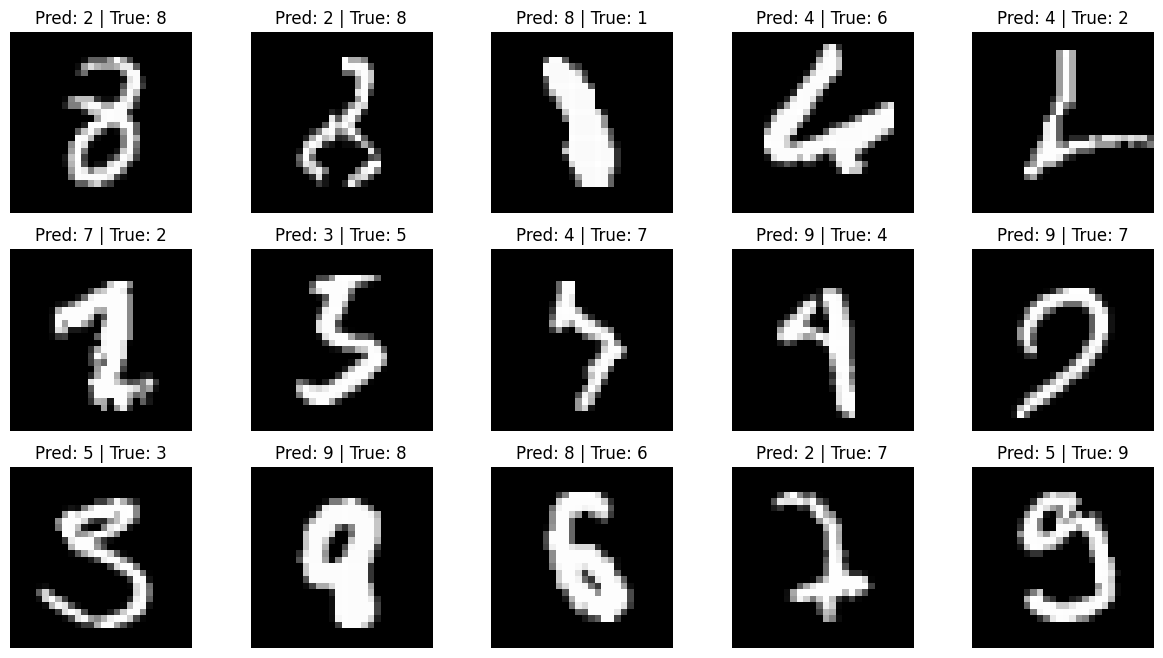

In [79]:
prob = model.predict(x_test, verbose=0)
preds = np.argmax(prob, axis=1)

wrong_idx  = np.where(preds != y_test)[0]
print(f"Wrong predictions for {len(wrong_idx)} images")

plot_size = (3, 5)
figsize = (15, 8)
fig, axs = plt.subplots(*plot_size, figsize=figsize)
for i, ax in enumerate(axs.flatten()):
    wrong_index = wrong_idx[i]
    ax.imshow(x_test[wrong_index].squeeze(), cmap="gray")
    ax.set_title(f"Pred: {preds[wrong_index]} | True: {y_test[wrong_index]}")
    ax.axis("off")
plt.show()

#### Pool layers visualisation

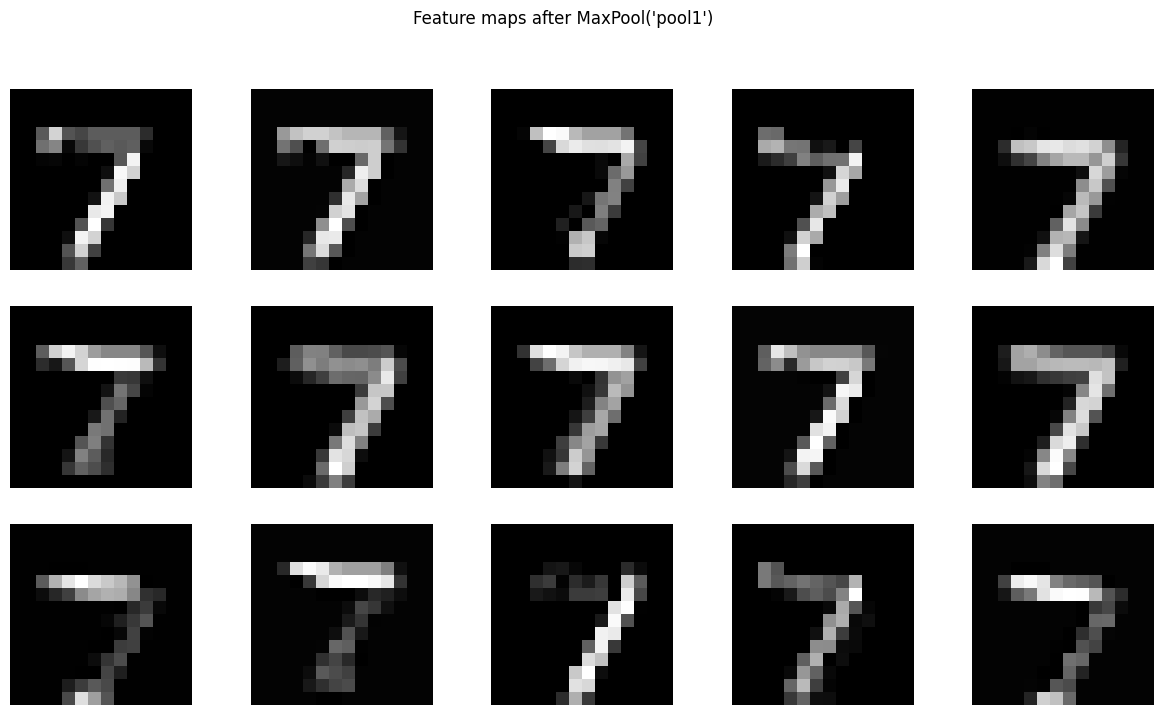

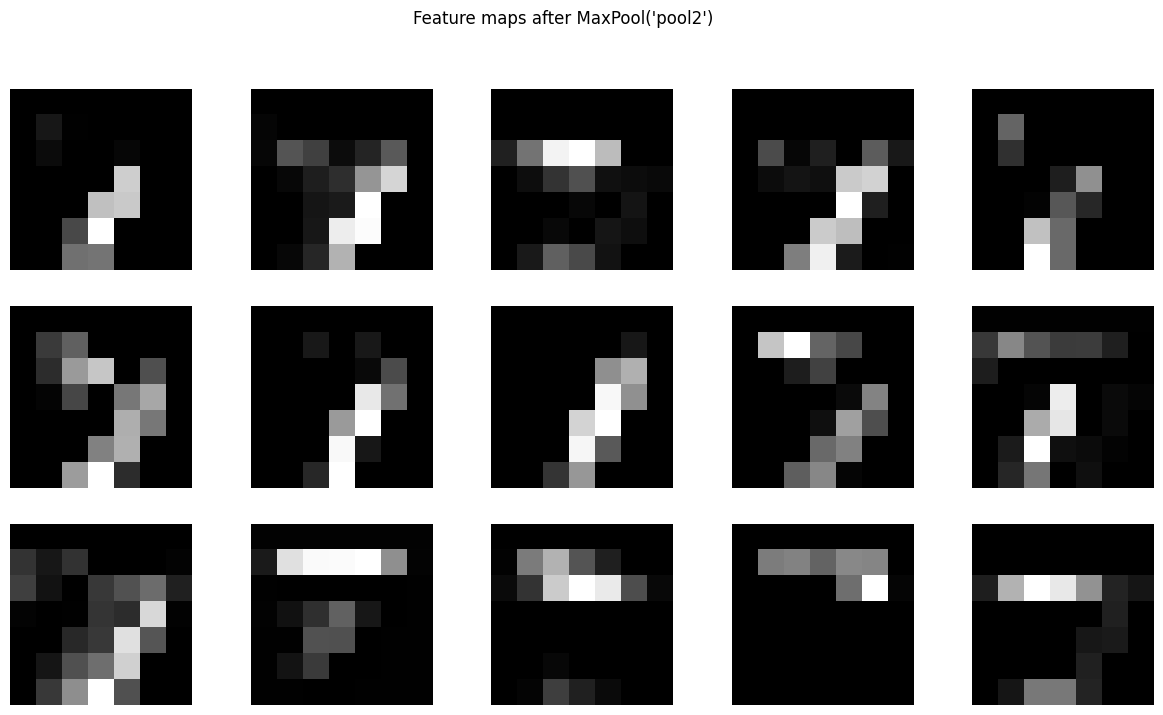

In [69]:
for pool_name in ["pool1", "pool2"]:
    probe = keras.Model(inputs=model.input, outputs=model.get_layer(pool_name).output)

    fig, axs = plt.subplots(*plot_size, figsize=figsize)
    for i, ax in enumerate(axs.flatten()):
        feat = probe.predict(x_test[:1], verbose=0)[0]
        
        ax.imshow(feat[:,:,i], cmap="gray"); ax.axis("off")
    fig.suptitle(f"Feature maps after MaxPool('{pool_name}')"); plt.show()

## Hyper-parameter Tuning

#### Filters enumeration

In [72]:
import pandas as pd

results = []
for filters in [16, 32, 64]:
    tf.keras.backend.clear_session()
    model = keras.Model(*build_model(filters=filters))
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )
    hist = model.fit(
        *(x_train, y_train),
        epochs=3,
        batch_size=128,
        validation_data=(x_val, y_val)
    )
    val_acc = float(hist.history["val_accuracy"][-1])
    results.append({"filters": filters, "val_acc": val_acc})

df = pd.DataFrame(results).sort_values("val_acc", ascending=False)
print("Validation results:\n", df.to_string(index=False))

Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8842 - loss: 0.3828 - val_accuracy: 0.9763 - val_loss: 0.0835
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9631 - loss: 0.1198 - val_accuracy: 0.9813 - val_loss: 0.0615
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9719 - loss: 0.0893 - val_accuracy: 0.9858 - val_loss: 0.0519
Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9068 - loss: 0.3086 - val_accuracy: 0.9778 - val_loss: 0.0733
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9676 - loss: 0.1036 - val_accuracy: 0.9840 - val_loss: 0.0529
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9756 - loss: 0.0770 - val_accuracy: 0.9878 - val_loss: 0.0404
Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9184 - loss: 0.2582 - val_accuracy: 0.9822 - val_loss: 0.0561
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9739 - loss: 0.0845 - val_accuracy: 0.9

#### Train model using one best filter

In [74]:
best_filters = int(df.iloc[0]["filters"])
print(f"\nBest by val_acc: filters={best_filters} → retraining on train set...")
tf.keras.backend.clear_session()
best_model = keras.Model(*build_model(filters=best_filters))
best_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
hist = best_model.fit(
    *(x_train, y_train),
    epochs=3,
    batch_size=128,
    validation_data=(x_val, y_val)
)


Best by val_acc: filters=64 → retraining on train set...
Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9200 - loss: 0.2533 - val_accuracy: 0.9792 - val_loss: 0.0710
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9741 - loss: 0.0849 - val_accuracy: 0.9898 - val_loss: 0.0402
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9799 - loss: 0.0640 - val_accuracy: 0.9897 - val_loss: 0.0315


In [76]:
logits = best_model.predict(x_test, verbose=0)
preds = np.argmax(logits, axis=1)

correct_idx = np.where(preds == y_test)[0]
wrong_idx   = np.where(preds != y_test)[0]
print(f"Correct: {len(correct_idx)} | Wrong: {len(wrong_idx)} out of {len(x_test)}")


test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy: {test_acc*100:.5f}%, Loss: {test_loss*100:.5f}%")

Correct: 9913 | Wrong: 87 out of 10000
Accuracy: 99.13000%, Loss: 2.49459%


Wrong predictions for 87 images


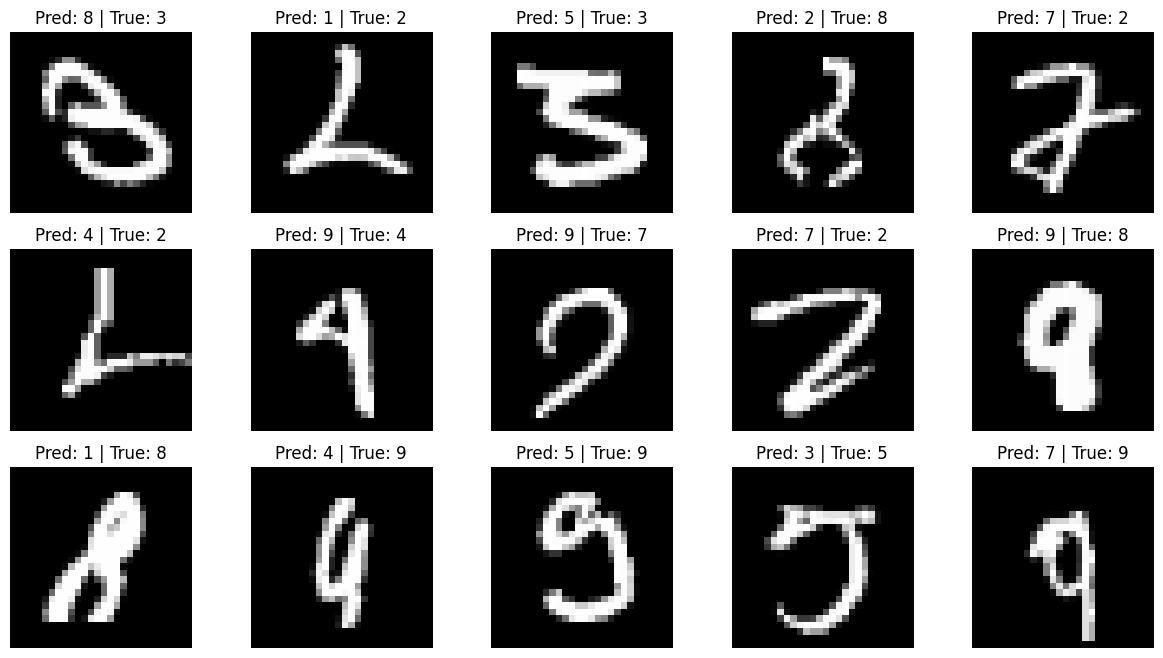

In [77]:
prob = best_model.predict(x_test, verbose=0)
preds = np.argmax(prob, axis=1)

wrong_idx  = np.where(preds != y_test)[0]
print(f"Wrong predictions for {len(wrong_idx)} images")

plot_size = (3, 5)
figsize = (15, 8)
fig, axs = plt.subplots(*plot_size, figsize=figsize)
for i, ax in enumerate(axs.flatten()):
    wrong_index = wrong_idx[i]
    ax.imshow(x_test[wrong_index].squeeze(), cmap="gray")
    ax.set_title(f"Pred: {preds[wrong_index]} | True: {y_test[wrong_index]}")
    ax.axis("off")
plt.show()